<a href="https://colab.research.google.com/github/joshgphilip/graphs/blob/main/Line_autoencode_tst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import networkx as nx
import torch
import gensim
import scipy
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
# !pip install --upgrade scipy==1.8.0 networkx 
import scipy
import networkx as nx
print('scipy: ', scipy.__version__)
print('nx: ', nx.__version__)
print('Starting')

scipy:  1.8.0
nx:  3.0
Starting


In [2]:
train_url = "https://raw.githubusercontent.com/joshgphilip/graphs/main/data/google-quest-challenge/train.csv"
test_url = "https://raw.githubusercontent.com/joshgphilip/graphs/main/data/google-quest-challenge/test.csv"
sample_sub_url = "https://raw.githubusercontent.com/joshgphilip/graphs/main/data/google-quest-challenge/sample_submission.csv"

train_df = pd.read_csv(train_url)
train_df.head(5)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,...,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


In [3]:
def showGraphStats(G):
  print('Number of nodes: ', G.number_of_nodes())
  print('Number of edges: ', G.number_of_edges())

G=nx.from_pandas_edgelist(train_df[:50],source='question_body',target='category')
showGraphStats(G)

Number of nodes:  55
Number of edges:  50


Total weight:  15.040000000000013


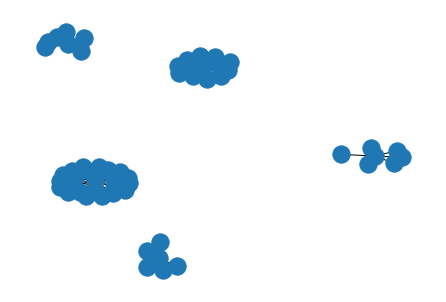

In [4]:
nx.draw(G)
wt = 0
# normalize the edge weights 
for e in G.edges():
    n1=e[0]
    n2=e[1]
    # print("-----")
    # print(n1, n2)
    n1_nbr =len([j for j in G.neighbors(n1)])
    n2_nbr =len([j for j in G.neighbors(n2)])
    # print(n1_nbr, G.degree(n1))
    if n1_nbr != G.degree(n1):
      print('Degree mismatch : ', n1)
    if n2_nbr != G.degree(n2):
      print('Degree mismatch : ', n2)
    # if n1=='CULTURE' or n2 =='CULTURE':
    #  print('Culture degree: ', G.degree(n1))
    G[n1][n2]['weight'] = (G.degree(n1) + G.degree(n2)) / G.number_of_edges()
    # print('Weight: ', G[n1][n2]['weight'])
    wt += G[n1][n2]['weight']
print('Total weight: ', wt)
# print(G.degree())  # print all nodes and their associated degrees


,Q1,Qn
0,After playing around with macro photography on...,I am trying to understand what kinds of places...
1,After playing around with macro photography on...,I'm working on a PCB that has through-hole com...
2,After playing around with macro photography on...,"An affidavit, from what i understand, is basic..."


Adjaceny Matrix A   (0, 1)	1
  (1, 0)	1
  (1, 7)	1
  (2, 3)	1
  (3, 2)	1
  (3, 6)	1
  (4, 5)	1
  (5, 4)	1
  (6, 3)	1
  (7, 1)	1
idx:  [0 1 2 3 4 5 6 7]
degree vals:  [1 2 1 2 1 1 1 1]
Degree matrix:    (0, 0)	1
  (1, 1)	2
  (2, 2)	1
  (3, 3)	2
  (4, 4)	1
  (5, 5)	1
  (6, 6)	1
  (7, 7)	1
Laplacian:    (0, 0)	1
  (0, 1)	-1
  (1, 0)	-1
  (1, 1)	2
  (1, 7)	-1
  (2, 2)	1
  (2, 3)	-1
  (3, 2)	-1
  (3, 3)	2
  (3, 6)	-1
  (4, 4)	1
  (4, 5)	-1
  (5, 4)	-1
  (5, 5)	1
  (6, 3)	-1
  (6, 6)	1
  (7, 1)	-1
  (7, 7)	1
L graph:  Graph with 8 nodes and 13 edges


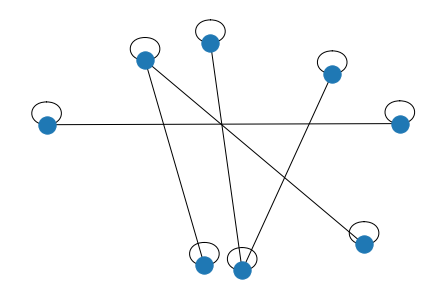

In [22]:
G=nx.from_pandas_edgelist(train_df[:5],source='question_body',target='category')
#nx.draw(g)

df=pd.DataFrame(columns=['Q1','Qn'])
df['Q1']=[train_df['question_body'][0]]*1000
list_ques=[]
for i in range(1001):
    if i!=0:
        list_ques.append(train_df['question_body'][i])
df['Qn']=list_ques
display(df.head(3))
G2=nx.from_pandas_edgelist(df,source='Q1',target='Qn')
# nx.draw(G2)
A=nx.adjacency_matrix(G, nodelist=G.nodes()) 
print('Adjaceny Matrix A', A)
# nx.draw(G)
num_nodes = G.number_of_nodes()
idx=np.arange(num_nodes)
print('idx: ',  idx)
degree_vals=np.array([(G.degree[node]) for node in list(G.nodes())])
print('degree vals: ', degree_vals)
   # put degrees on diagonal -- so can calculate laplacian
D=scipy.sparse.coo_matrix((degree_vals,(idx,idx)),shape=(num_nodes,num_nodes))
print('Degree matrix: ', D)
L=D - A    # get another adjacency matrix that is laplacian
print('Laplacian: ' , L)
  # nx.from_scipy_sparse_array --Creates a new graph from an adjacency matrix given as a SciPy sparse array.
L2=nx.from_scipy_sparse_array(L)  
print('L graph: ', L2)
nx.draw(L2)

In [15]:
class SDNE():
    def __init__(self,G,alpha,beta,hidden_dims):
        self.G=G
        self.num_nodes = self.G.number_of_nodes()
        self.alpha=alpha
        self.beta=beta
        self.hidden_dims=hidden_dims
        # self.A=nx.adjacency_matrix(self.G, nodelist=range(self.num_nodes))
        self.A=nx.adjacency_matrix(self.G, nodelist=self.G.nodes())  ### NOTE: needs scipy = 1.8 version to work
        idx=np.arange(self.num_nodes)
        degree_vals=np.array([(self.G.degree[node]) for node in list(self.G.nodes())])
        
        ##(data,row,columns)
        self.D=scipy.sparse.coo_matrix((degree_vals,(idx,idx)),shape=(self.num_nodes,self.num_nodes))
        ## self.D=nx.from_scipy_sparse_matrix(D)
        
        L=self.D-self.A 
        L=nx.from_scipy_sparse_array(L)
        # self.L=nx.laplacian_matrix(L)
        # self.inputs=[self.A,self.L]
        self.embeddings=[]
        self.node_size=self.num_nodes
        # self.model()



In [16]:
hidden_dims=[32,16]
alpha=1e-4
beta=1e-5
sdne=SDNE(G,alpha,beta,hidden_dims)

AttributeError: ignored